In [4]:
#########
# Import
#########

import pandas as pd
import numpy as np
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import traceback

from scipy import signal
from scipy.signal import butter, filtfilt, iirnotch
from scipy.ndimage import gaussian_filter
#import cupy as cp
import torch

import warnings
warnings.filterwarnings('ignore')

import kagglehub
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [5]:
#######
# Data
#######

hms_harmful_brain_activity_classification_path = kagglehub.competition_download('hms-harmful-brain-activity-classification')
print('Data source import complete.')

train_df = pd.read_csv("/root/.cache/kagglehub/competitions/hms-harmful-brain-activity-classification/train.csv")
train_eeg_path = "/root/.cache/kagglehub/competitions/hms-harmful-brain-activity-classification/train_eegs"

100%|██████████| 18.4G/18.4G [02:16<00:00, 145MB/s]

Extracting files...


Data source import complete.


"""<h1 style="color:#002F6C; font-weight: bold; font-size: 40px; font-family:'Times New Roman', Times, serif;">STEP 1: DATA PREPROCESSING</h1>"""


In [ ]:
def handle_nan_values(df, sample_rate=200):
    df_processed = df.copy()
    stats = {
        'original_rows': len(df),
        'edge_nans_removed': 0,
        'interpolated_ranges': 0}
    all_nan_rows = df_processed.isna().all(axis=1)

    if all_nan_rows.any():
        first_valid_idx = 0
        while first_valid_idx < len(df_processed) and all_nan_rows.iloc[first_valid_idx]:
            first_valid_idx += 1

        last_valid_idx = len(df_processed) - 1
        while last_valid_idx >= 0 and all_nan_rows.iloc[last_valid_idx]:
            last_valid_idx -= 1

        if first_valid_idx > 0 or last_valid_idx < len(df_processed) - 1:
            df_processed = df_processed.iloc[first_valid_idx:last_valid_idx + 1].copy()
            stats['edge_nans_removed'] = (first_valid_idx + (len(df) - 1 - last_valid_idx))

    for column in df_processed.columns:
        nan_mask = df_processed[column].isna()

        if not nan_mask.any():
            continue

        nan_groups = nan_mask.ne(nan_mask.shift()).cumsum()[nan_mask]

        for group_id in nan_groups.unique():
            group_indices = nan_groups[nan_groups == group_id].index
            group_size = len(group_indices)
            group_duration = group_size / sample_rate

            if group_duration <= 2:
                stats['interpolated_ranges'] += 1
                try:
                    df_processed[column].loc[group_indices] = df_processed[column].interpolate(method='cubic').loc[group_indices]
                except:
                    try:
                        df_processed[column].loc[group_indices] = df_processed[column].interpolate(method='linear').loc[group_indices]
                    except:
                        df_processed[column].loc[group_indices] = df_processed[column].interpolate(method='nearest').loc[group_indices]
            else:
                df_processed[column].loc[group_indices] = df_processed[column].interpolate(method='linear').loc[group_indices]

    return df_processed, stats

> **Missing Data at the Beginning and End:**

I deleted the completely missing lines at the beginning and end because they usually occur as a result of situations such as not being able to receive a signal from the device or the end of the measurement. These lines should not be included in the analysis, so it was cleared.

> **2 Second Threshold and Interpolation:**

I set the 2-second threshold myself. If the duration of the missing values is shorter than 2 seconds, I filled it with more sensitive methods. In long-term incomplete data, I used simpler techniques such as linear interpolation."""


In [ ]:
def process_all_eeg_files(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    files = [f for f in os.listdir(input_dir) if f.endswith('.parquet')]

    stats = {'total_files': len(files),
        'processed_files': 0,
        'files_with_nan': 0,
        'total_edge_nans_removed': 0,
        'total_interpolated_ranges': 0,
        'file_stats': {},
        'error_files': []}

    for file in tqdm(files):
        try:
            df = pd.read_parquet(os.path.join(input_dir, file))

            if df.isna().any().any():
                stats['files_with_nan'] += 1

            df_processed, file_stats = handle_nan_values(df)

            stats['file_stats'][file] = file_stats
            stats['total_edge_nans_removed'] += file_stats['edge_nans_removed']
            stats['total_interpolated_ranges'] += file_stats['interpolated_ranges']

            output_file = os.path.join(output_dir, f"processed_{file}")
            df_processed.to_parquet(output_file)

            stats['processed_files'] += 1

        except Exception as e:
            stats['error_files'].append({'file': file, 'error': str(e)})

    return stats

input_directory = "/root/.cache/kagglehub/competitions/hms-harmful-brain-activity-classification/train_eegs"
output_directory = "/content/drive/MyDrive/HMS_kaggle_comp/cleaned_data"

stats = process_all_eeg_files(input_directory, output_directory)

In [ ]:
#columns_to_check = ['expert_consensus', 'seizure_vote', 'lpd_vote',
#                    'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']

#consistency_check = (train_df.groupby('eeg_id')[columns_to_check].apply(lambda group: group.nunique().gt(1).any()))

#if consistency_check.any():
#    print("The values of the columns specified in at least one eeg_id group are different.")
#else:
#    print("The values of the specified columns in all eeg_id groups are the same.")


### ***The values of the columns specified in at least one eeg_id group are different.***




# def check_eeg_label_offset_seconds(csv_path):
#    df = pd.read_csv(csv_path)
#        df_sorted = df.sort_values(['eeg_id', 'eeg_label_offset_seconds'])
#    first_rows = df_sorted.groupby('eeg_id').first()
#    non_zero_ids = first_rows[first_rows['eeg_label_offset_seconds'] != 0.0]

#    return {'total_eeg_ids': len(first_rows),
#        'non_zero_count': len(non_zero_ids),
#        'non_zero_details': non_zero_ids}

#def main(csv_path):
#    results = check_eeg_label_offset_seconds(csv_path)
#    print("EEG Label Offset Seconds Check Results:")
#    print("-" * 50)

#    print(f"Total unique EEG IDs: {results['total_eeg_ids']}")
#    print(f"Number of EEG IDs with non-zero first occurrence: {results['non_zero_count']}")

#    if results['non_zero_count'] > 0:
#        print("\nDetailed Non-Zero Cases:")
#        print(results['non_zero_details'])
#    else:
#        print("\nAll EEG IDs have 0.0 as the first occurrence's eeg_label_offset_seconds.")

#main("/kaggle/input/hms-harmful-brain-activity-classification/train.csv")

### ***All EEG IDs have 0.0 as the first occurrence's eeg_label_offset_seconds.***

<div style="font-family: 'Times New Roman'; font-weight: bold; font-size: 18px; line-height: 1.6;">
    <p style="text-align: justify;">I observed that there was more than one line from the same eeg_id and noticed that the votes given to the target columns could differ in each row. This discrepancy is most likely due to the examination of different 10-second slices for each eeg_id. Taking this situation into account, I grouped each eeg_id in itself, according to their voting status. In this way, either only one line or different lines were formed from each eeg_id. In the grouping process, I matched the offset_seconds values by taking min and max according to the time the data was examined.</p>
</div>

In [ ]:
drop_list = ["spectrogram_sub_id","label_id"]
train_df.drop(drop_list, axis=1, inplace=True)

targets = ["seizure_vote", "lpd_vote", "gpd_vote", "lrda_vote", "grda_vote", "other_vote"]
train_df['vote_sum'] = train_df[targets].sum(axis=1)
train_df['combined_id'] = train_df['eeg_id'].astype(str) + '_' + train_df['expert_consensus'] + '_' + train_df['seizure_vote'].astype(str) + train_df['lpd_vote'].astype(str) + train_df['gpd_vote'].astype(str) + train_df['lrda_vote'].astype(str) + train_df['grda_vote'].astype(str) + train_df['other_vote'].astype(str)


train_df = train_df.groupby(['eeg_id', 'combined_id'], as_index=False).agg(
    eeg_label_offset_seconds_min=('eeg_label_offset_seconds', 'min'),
    eeg_label_offset_seconds_max=('eeg_label_offset_seconds', 'max'),
    spectrogram_label_offset_seconds_min=("spectrogram_label_offset_seconds","min"),
    spectrogram_label_offset_seconds_max=("spectrogram_label_offset_seconds","max"),
    patient_id=('patient_id', 'first'),
    expert_consensus=('expert_consensus', 'first'),
    seizure_vote=('seizure_vote', 'first'),
    lpd_vote=('lpd_vote', 'first'),
    gpd_vote=('gpd_vote', 'first'),
    lrda_vote=('lrda_vote', 'first'),
    grda_vote=('grda_vote', 'first'),
    other_vote=('other_vote', 'first'),
    votes_sum=("vote_sum", "first"),
    spectrogram_id=("spectrogram_id","first"))

<h1 style="color:#002F6C; font-weight: bold; font-size: 40px; font-family:'Times New Roman', Times, serif;">STEP 2: SIGNAL PREPROCESSING</h1>

<div style="font-family: 'Times New Roman'; font-weight: bold; font-size: 18px; line-height: 1.6;">
    <p style="text-align: justify;">As a result of my research, I came to the conclusion that a wide area scan should be performed for seizure detection, and certain brain regions are more critical for dominant activity detection. I determined the most suitable electrode placements for our seizure prediction and dominant activity detection work problem as follows:</p>
    <hr style="border: 1px solid #ccc;">
    <h3 style="color: #34495E;">Electrodes for Wide Field Scanning:</h3>
    <ul style="margin-left: 20px;">
        <li><strong>Fp1, Fp2 (Frontopolar):</strong> It monitors activities in the front part of the brain, provides clues about the onset of seizures.</li>
        <li><strong>F3, F4, Fz (Frontal):</strong> The frontal region is related to decision-making, motor control, and emotional reactions. Seizures are usually known to start from the frontal lobe.</li>
        <li><strong>C3, C4, Cz (Central):</strong> These regions, related to motor and somatosensory functions, are important for monitoring the ways the seizures spread.</li>
        <li><strong>P3, P4, Pz (Parietal):</strong> The parietal lobe is related to body sensation and spatial perception. Seizures can also be detected in these regions.</li>
        <li><strong>O1, O2 (Occipital):</strong> The occipital lobe, which is a visual processing center, is critical for monitoring seizures that start in visual areas.</li>
    </ul>
    <hr style="border: 1px solid #ccc;">
    <h3 style="color: #34495E;">Electrodes for Dominant Activity Detection:</h3>
    <ul style="margin-left: 20px;">
        <li><strong>F7, F8 (Lateral Frontal):</strong> The lateral frontal region is related to motor and decision-making processes. It is very useful to detect dominant activity in these areas.</li>
        <li><strong>T3, T4 (Temporal):</strong> The temporal lobe includes important functions such as memory, sensory processing, and language. This area is where seizures often begin.</li>
        <li><strong>T5, T6 (Posterior Temporal):</strong> The posterior temporal region is linked to visual and auditory information processing, and the dominant activities observed here are important for monitoring the seizure spread.</li>
    </ul>
    <hr style="border: 1px solid #ccc;">
    <p style="text-align: justify;">These electrode placements provide optimal options for effectively monitoring activities in different areas of the brain, detecting the starting and spread points of seizures.</p>
</div>

![](http://uploads-ssl.webflow.com/5e2b590ca27de6be81c64780/5e8ad2dca6b2c1434cac8025_Double_Banana_Setup_(flat)-17-p-2000.png)

> **You can reach the site I find most useful to better understand EEG, electrodes and assemblies from this link **[here](https://www.learningeeg.com/montages-and-technical-components)****

# Artifact Removal

Artifacts in EEG data are unwanted signals that distort the recorded signal and prevent accurate analysis. Artifact cleaning is a technique used to remove the signal from unwanted noise (e.g., eye movements, muscle activities, ECG, etc.).

I preferred these ranges because EEG signals usually contain important information at frequencies between 0.5 Hz and 40 Hz. Frequencies below 0.5 Hz are often associated with low-frequency noise or motion artifacts, so starting at 0.5 Hz I began to capture important signals. The range up to 40 Hz includes delta, theta, alpha, beta and gamma bands, which are especially critical for detecting abnormal brain activities such as seizures. I also applied a notch filter to clear power line noise around 60Hz. This frequency range contains important frequency information, widely used in seizure detection and other brain activity analyses.

In [ ]:
#####################
# Class Morlet Wavelet
#####################

class Morlet:
    def __init__(self, w0=6):
        self.w0 = w0
        self.C_d = 0.776 if w0 == 6 else None

    def time(self, t, s=1.0, complete=True):
        w = self.w0
        x = cp.asarray(t) / s
        output = cp.exp(1j * w * x - 0.5 * (x ** 2)) * cp.pi ** (-0.25)
        if complete:
            output -= cp.exp(-0.5 * (w ** 2))
        return output

    def scale_from_period(self, period):
        return (period * (np.sqrt(self.w0 * self.w0 + 2) + self.w0)) / (4.0 * np.pi)

    def coi(self, s):
        return np.sqrt(2) * s

In [ ]:
########################
# Class Signal Processor
########################

class EEGProcessor:
    def __init__(self, fs=200, freq_range=(0.5, 40), device='cuda'):
        self.fs = fs
        self.freq_range = freq_range
        self.wavelet = Morlet(w0=6)
        self.bandpass_coeffs, self.notch_coeffs = self._prepare_filters()
        self.device = device

    def _prepare_filters(self):
        nyquist_freq = 0.5 * self.fs
        low_cut = self.freq_range[0] / nyquist_freq
        high_cut = self.freq_range[1] / nyquist_freq
        bandpass_b, bandpass_a = signal.butter(5, [low_cut, high_cut], btype='band')
        notch_b, notch_a = signal.iirnotch(w0=60, Q=30, fs=self.fs)
        return (bandpass_b, bandpass_a), (notch_b, notch_a)

    def _apply_filters(self, signal_data):
        if torch.is_tensor(signal_data):
            signal_data = signal_data.cpu().numpy()
        filtered = signal.filtfilt(*self.notch_coeffs, signal_data)
        filtered = signal.filtfilt(*self.bandpass_coeffs, filtered)
        return filtered

    def _calculate_channel_metrics(self, signal_data):
        signal_gpu = cp.asarray(signal_data)
        power = float(cp.mean(signal_gpu ** 2))
        kernel = cp.ones(20) / 20
        smoothed = cp.convolve(signal_gpu, kernel, mode='same')
        noise = signal_gpu - smoothed
        snr = power / float(cp.std(noise) ** 2) if float(cp.std(noise)) != 0 else 0
        freqs = cp.fft.rfftfreq(len(signal_gpu), d=1/self.fs)
        psd = cp.abs(cp.fft.rfft(signal_gpu)) ** 2
        total_power = float(cp.sum(psd))
        cumsum_power = cp.cumsum(psd) / total_power
        sef_95 = float(freqs[cp.where(cumsum_power >= 0.95)[0][0]])
        scales = cp.arange(1, 31)
        coeffs = cp.array([
            cp.convolve(signal_gpu, self.wavelet.time(cp.arange(len(signal_gpu)) - len(signal_gpu)//2, s), mode='same')
            for s in scales])
        wavelet_energy = float(cp.mean(cp.abs(coeffs)))

        return {'power': power,'snr': snr,'sef': sef_95,'wavelet_energy': wavelet_energy}

    def _create_cwt_spectrogram(self, signal_data, num_freqs=100):
        min_freq, max_freq = self.freq_range
        scales = cp.logspace(
            cp.log10(self.fs/max_freq),
            cp.log10(self.fs/min_freq),
            num_freqs)

        signal_gpu = cp.asarray(signal_data)
        time_grid = cp.arange(len(signal_gpu)) - len(signal_gpu)//2

        cwt_matrix = cp.zeros((len(scales), len(signal_gpu)), dtype=cp.complex64)

        for idx, scale in enumerate(scales):
            wavelet_data = self.wavelet.time(time_grid, scale)
            cwt_matrix[idx] = cp.convolve(signal_gpu, wavelet_data, mode='same')

        return cwt_matrix

    def process_channels(self, eeg_data, bipolar_pairs, reference_pairs):
        processed_signals = {}
        channel_metrics = {}

        for name, (ch1, ch2) in bipolar_pairs.items():
            if ch1 in eeg_data.columns and ch2 in eeg_data.columns:
                signal = eeg_data[ch1].values - eeg_data[ch2].values
                filtered_signal = self._apply_filters(signal)
                processed_signals[name] = filtered_signal
                channel_metrics[name] = self._calculate_channel_metrics(filtered_signal)

        for name, (electrode, _) in reference_pairs.items():
            if electrode in eeg_data.columns:
                signal = eeg_data[electrode].values
                filtered_signal = self._apply_filters(signal)
                processed_signals[name] = filtered_signal
                channel_metrics[name] = self._calculate_channel_metrics(filtered_signal)

        weights = self._calculate_weights(channel_metrics)
        return processed_signals, weights

    def _calculate_weights(self, metrics):
        weights = {}
        for channel, channel_metrics in metrics.items():
            normalized_metrics = {}
            for key, value in channel_metrics.items():
                all_values = [m[key] for m in metrics.values()]
                min_val, max_val = min(all_values), max(all_values)
                if max_val > min_val:
                    normalized_metrics[key] = (value - min_val) / (max_val - min_val)
                else:
                    normalized_metrics[key] = 1.0

            weights[channel] = (
                0.3 * normalized_metrics['power'] +
                0.3 * normalized_metrics['snr'] +
                0.2 * normalized_metrics['sef'] +
                0.2 * normalized_metrics['wavelet_energy'])

        total_weight = sum(weights.values())
        weights = {k: v/total_weight for k, v in weights.items()}
        return weights

    def create_spectrogram_image(self, eeg_data, start_time, duration, image_size=(224, 224), num_freqs=100, bipolar_pairs=None, reference_pairs=None):
        start_idx = int(start_time * self.fs)
        end_idx = start_idx + int(duration * self.fs)
        data_slice = eeg_data.iloc[start_idx:end_idx]

        processed_signals, weights = self.process_channels(data_slice, bipolar_pairs, reference_pairs)
        spectrogram_image = cp.zeros((image_size[0], image_size[1], 3), dtype=cp.float32)

        for name, signal in processed_signals.items():
            weight = weights[name]
            cwt = self._create_cwt_spectrogram(signal, num_freqs=num_freqs)
            spectrogram = cp.abs(cwt)
            spectrogram = cp.log1p(spectrogram)
            spectrogram = (spectrogram - spectrogram.min()) / (spectrogram.max() - spectrogram.min())

            spectrogram_resized = cv2.resize(cp.asnumpy(spectrogram), (image_size[1], image_size[0]))
            spectrogram_resized = cp.asarray(spectrogram_resized)

            for i in range(3):
                spectrogram_image[:, :, i] += spectrogram_resized * weight

        spectrogram_image = (spectrogram_image * 255).astype(cp.uint8)
        spectrogram_image = cv2.applyColorMap(cp.asnumpy(spectrogram_image), cv2.COLORMAP_JET)

        return spectrogram_image, weights

In [ ]:
def process_dataset(data_df, output_path, processor, bipolar_pairs, reference_pairs, durations=[10, 50], batch_size=16):
    os.makedirs(output_path, exist_ok=True)

    with open(os.path.join(output_path, 'labels.csv'), 'w') as label_file:
        label_file.write('image_name,seizure,lpd,gpd,lrda,grda,other,channel_weights\n')

        for i in range(0, len(data_df), batch_size):
            batch = data_df.iloc[i:i+batch_size]

            for idx, row in tqdm(batch.iterrows(), total=len(batch)):
                try:
                    eeg_id = row['eeg_id']
                    start_time = row['eeg_label_offset_seconds_min']
                    eeg_data = pd.read_parquet(f'/content/drive/MyDrive/HMS_kaggle_comp/cleaned_data/processed_{eeg_id}.parquet')

                    for duration in durations:
                        image_name = f'{eeg_id}_{start_time}_duration_{duration}.png'
                        output_image_path = os.path.join(output_path, image_name)

                        if os.path.exists(output_image_path):
                            print(f"Skipping existing image: {image_name}")
                            continue

                        spectrogram_img, weights = processor.create_spectrogram_image(
                            eeg_data, start_time, duration=duration,
                            bipolar_pairs=bipolar_pairs, reference_pairs=reference_pairs)

                        cv2.imwrite(output_image_path, spectrogram_img)

                        labels = [
                            row['seizure_vote'], row['lpd_vote'], row['gpd_vote'],
                            row['lrda_vote'], row['grda_vote'], row['other_vote']]

                        label_file.write(f'{image_name},{",".join(map(str, labels))},{weights}\n')

                except Exception as e:
                    print(f"Error processing row {idx}: {e}")
                    continue

            torch.cuda.empty_cache()
            cp.get_default_memory_pool().free_all_blocks()

processor = EEGProcessor(device='cuda')
bipolar_pairs, reference_pairs = prepare_hybrid_montage_pairs()

process_dataset(train_df, "/content/drive/MyDrive/HMS_kaggle_comp/spectrograms_new",
    processor,bipolar_pairs,reference_pairs,durations=[10, 50],batch_size=256)

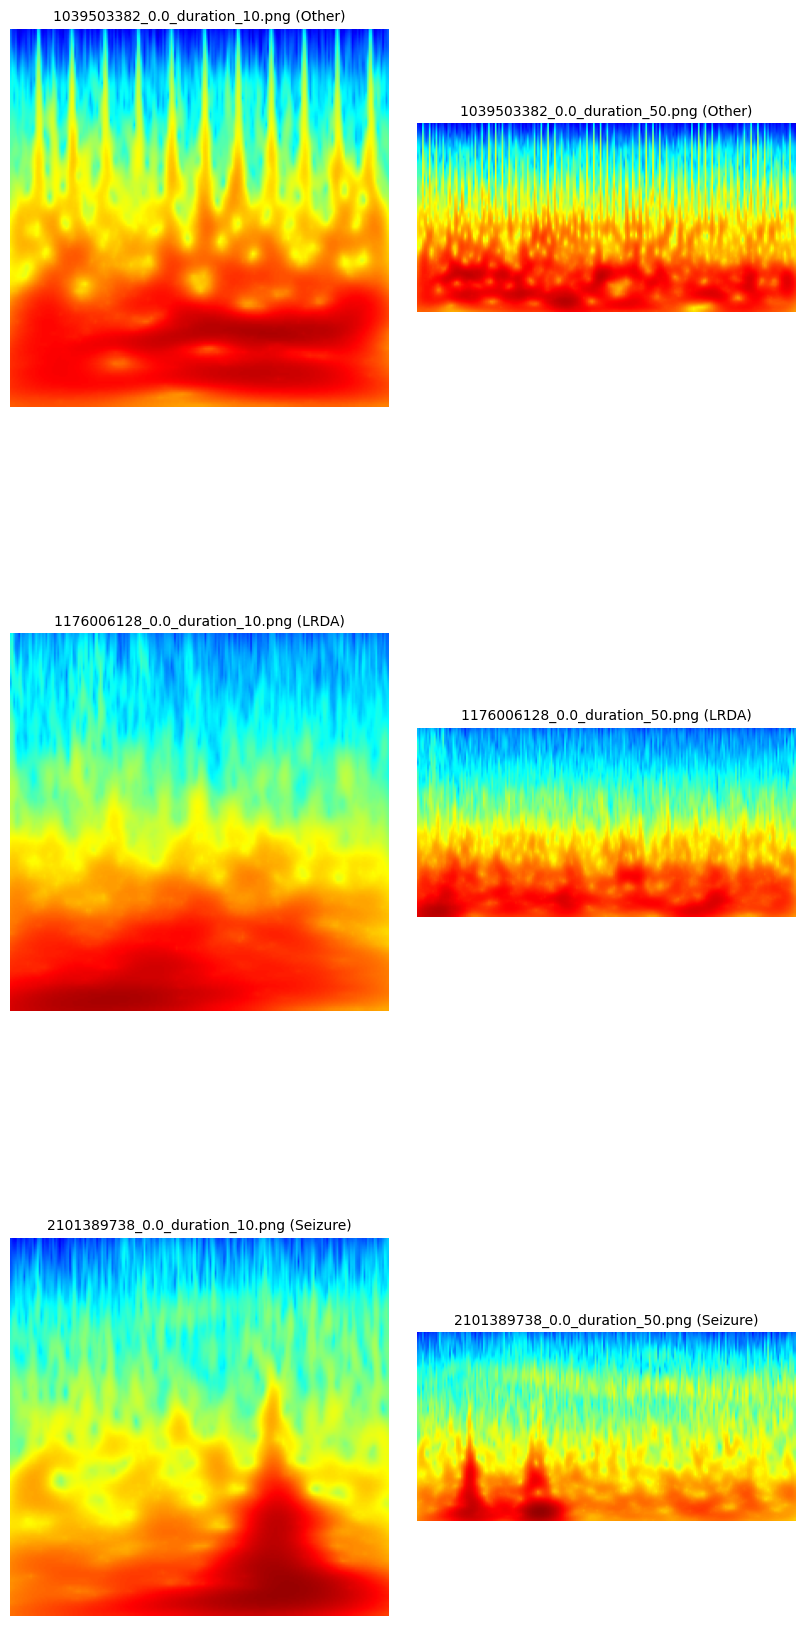

In [38]:
###############
# Visualization
###############


import matplotlib.image as mpimg

base_path = "/content/drive/MyDrive/HMS_kaggle_comp/spectrograms_new"
image_files = [
    ("1039503382_0.0_duration_10.png", "Other"),
    ("1039503382_0.0_duration_50.png", "Other"),
    ("1176006128_0.0_duration_10.png", "LRDA"),
    ("1176006128_0.0_duration_50.png", "LRDA"),
    ("2101389738_0.0_duration_10.png", "Seizure"),
    ("2101389738_0.0_duration_50.png", "Seizure")]


grouped_files = {}
for file, label in image_files:
    key = "_".join(file.split("_")[:2])
    if key not in grouped_files:
        grouped_files[key] = []
    grouped_files[key].append((file, label))

fig, axes = plt.subplots(nrows=len(grouped_files), ncols=2, figsize=(8, 6 * len(grouped_files)))
fig.tight_layout(pad=-1.0)


for i, (key, files) in enumerate(grouped_files.items()):
    file_10, label_10 = [(f, lbl) for f, lbl in files if "duration_10" in f][0]
    file_50, label_50 = [(f, lbl) for f, lbl in files if "duration_50" in f][0]

    img_10 = mpimg.imread(os.path.join(base_path, file_10))
    img_50 = mpimg.imread(os.path.join(base_path, file_50))

    axes[i, 0].imshow(img_10)
    axes[i, 0].set_title(f"{file_10} ({label_10})", fontsize=10)
    axes[i, 0].axis('off')

    img_50_stretched = np.repeat(img_50, 2, axis=1)
    axes[i, 1].imshow(img_50_stretched)
    axes[i, 1].set_title(f"{file_50} ({label_50})", fontsize=10)
    axes[i, 1].axis('off')

plt.show();